## Анализ А/В тестирования

В этом задании будем исследовать данные о пользователях, участвовавших в А/В тестировании, 
которое проходило с 2023-10-25 по 2023-10-31 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

#### Задачи:
1. Выбрать метод анализа и сравнить CTR в двух группах.

2. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.

### 1. Подготовка к работе

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.api as sm
%matplotlib inline

### 2. Загрузка данных

In [2]:
#параметры соединения 
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231113',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


### 3. Анализ данных

Отобразим на графиках распределение CTR 1 и 2 групп после эксперимента

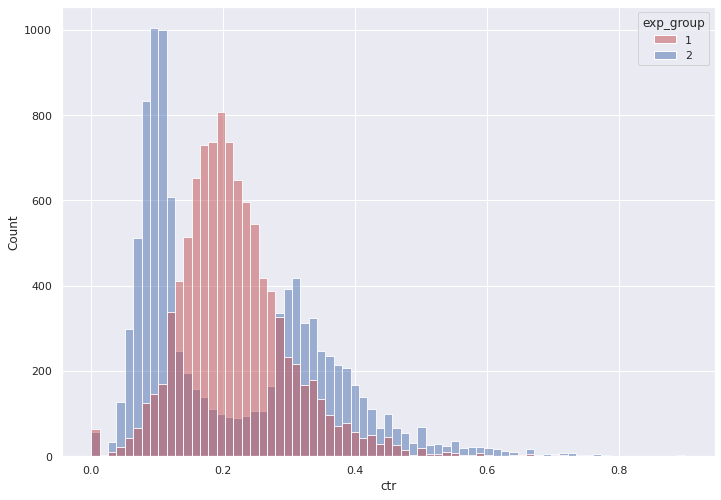

In [4]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

# построим гистограммы распределения значений CTR после эксперимента
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [7]:
# и посчитаем среднее значение CTR для обеих групп
df[['ctr','exp_group']].groupby('exp_group').mean()

,ctr
exp_group,
1,0.216774
2,0.216102


Среднее CTR в группах значительно не отличается. Однако, распределение CTR в экспериментальной группе значительно отличается от распределения в контрольной группе. Его даже можно отнести к бимодальному. Мы видим, что для части группы пользователей CTR стал ниже, а для другой наоборот вырос.

### 3.1 Cравнение CTR статистическими тестами


*Гипотеза:* Выдвинем гипотезу, что при использовании нового алгоритма в экспериментальной группе 1, CTR увеличится.

*Нулевая гипотеза:* средние значения CTR в контрольной и экспериментальной группaх равны.

*Альтернативная гипотеза:* средние значения CTR в экспериментальной группе выше значений в контрольной.

*Пороговое значение p-value:* 0.05

#### t-test


In [8]:
_, pvalue = stats.ttest_ind(df[df.exp_group == 1].ctr,
                            df[df.exp_group == 2].ctr,
                            equal_var=False)
print('T-test:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value:', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

T-test:
Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value: 0.685373331140751


T-тест не смог обнаружить различия CTR в контрольной и экспериментальной группе. Возможно, это из-за того, что распределение в экспериментальной группе бимодальное.

Попробуем «сгладить» наши оценки CTR и снова применить т-тест.

#### t-test на "сглаженном" CTR (α=5), метод Smoothed

In [9]:
#функция расчета сглаженного ctr 
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

#рассчитаем общий CTR для двух групп
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [10]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

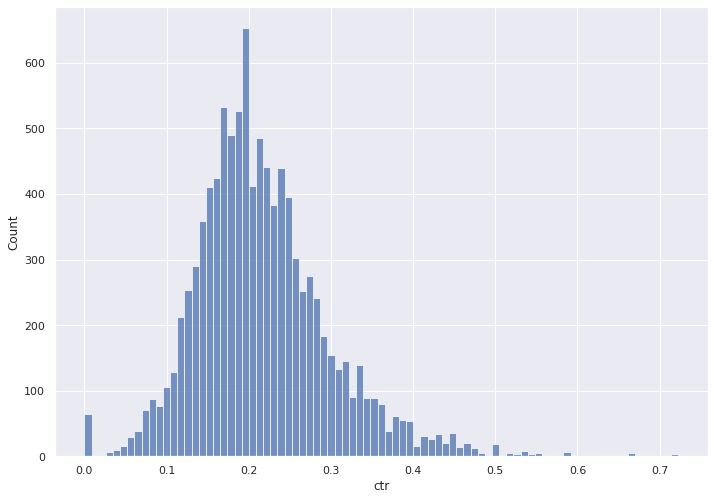

In [16]:
sns.histplot(group1.ctr, 
             kde = False);

In [12]:
#посчитаем сглаженный ctr для двух групп
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

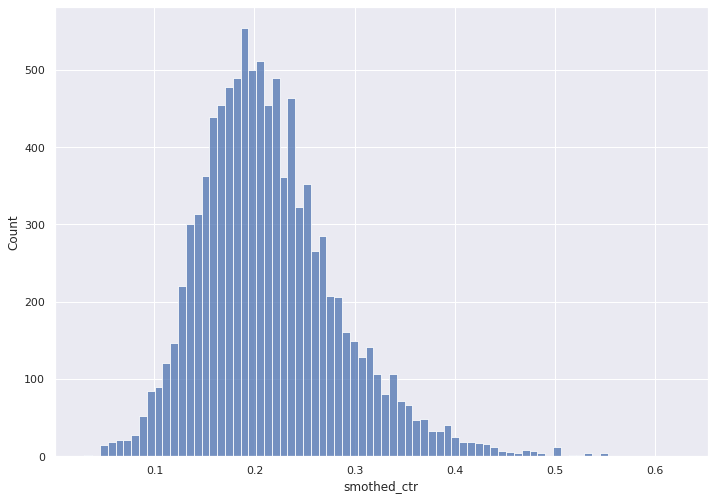

In [13]:
sns.histplot(group1.smothed_ctr, 
             kde = False);

In [19]:
#t-тест на сглаженном ctr
_, pvalue = stats.ttest_ind(group1.smothed_ctr,
                             group2.smothed_ctr,
                             equal_var=False)

print('T-test на сглаженном ctr:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value:', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

T-test на сглаженном ctr:
Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value: 0.05166679015318526


Вывод из т-теста для "сглаженного" CTR такой же, но всё же значение p-value получилось гораздо ниже и близко к α=5%.

#### Тест Манна-Уитни

Нулевая гипотеза: P(А > В) = P(А < В)

In [18]:
_, pvalue = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                               df[df.exp_group == 2].ctr,
                               alternative = 'two-sided')

print('тест Манна-Уитни:')
if pvalue > 0.05:
    print('Различия не обнаружены, p-value:', pvalue)
else:
    print('Статистически значимые различия, p-value:', pvalue)

тест Манна-Уитни:
Статистически значимые различия, p-value: 4.632205841806026e-45


Тест Манна-Уитни показал противоположный результат. В данном случае критерий Манна-Уитни и полученный результат предпочтитетелен для использования, т.к. распределение CTR в экспериментальной группы нельзя отнести к нормальному.

#### Пуассоновский бутстреп

In [20]:
#функция рассчета пуассоновского бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [21]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

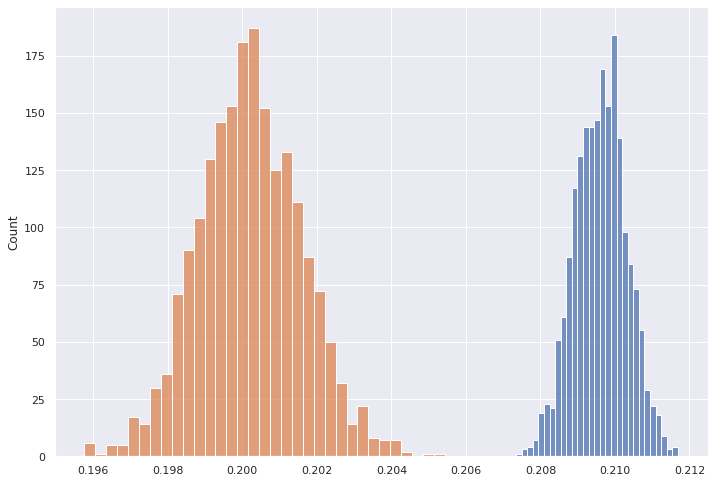

In [24]:
# построим распределение полученных ctr
sns.histplot(ctr1)
sns.histplot(ctr2);

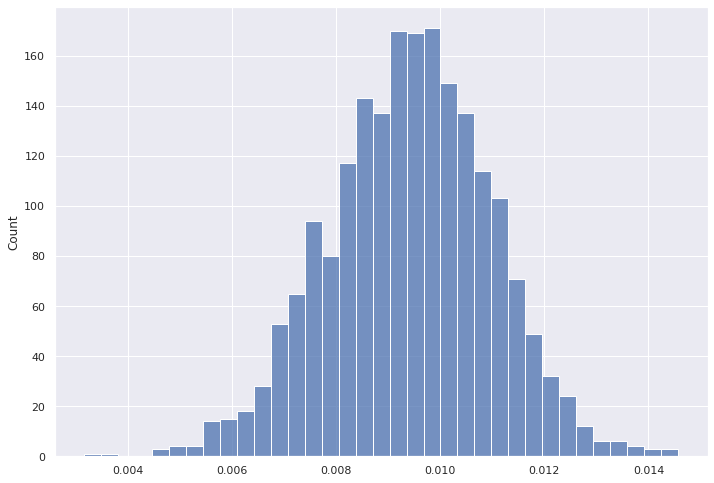

In [25]:
#Разница между глобальными CTR
sns.histplot(ctr1 - ctr2);

Анализ с помощью пуассоновского бутстрепа показал, что в контрольной группе лучшие результаты по CTR, чем в экспериментальной.

### t-тест и тест Манна-Уитни поверх бакетного преобразования

In [26]:
# тест Манна-Уитни поверх бакетного преобразования

q = """

SELECT exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id) % 50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20231020.feed_actions 
    WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

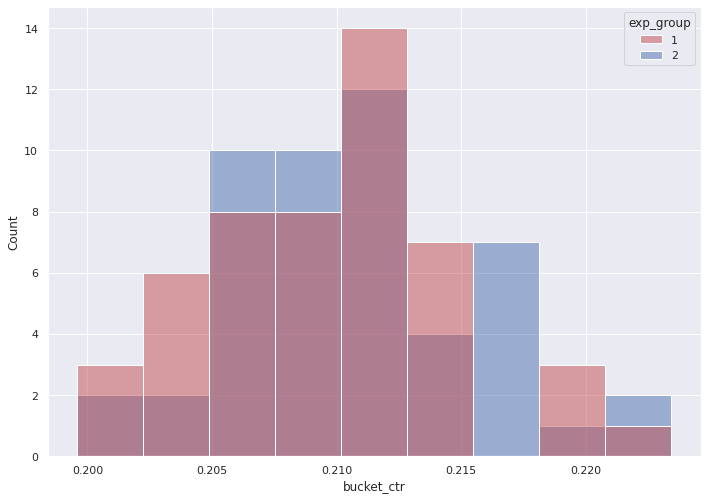

In [34]:
#посмотрим на распределения полученных значений ctr
sns.histplot(data = df_bucket,
            x='bucket_ctr',
            hue='exp_group',
            palette = ['r','b'],
            alpha=0.5,
            kde=False);

In [28]:
#тест Манна-Уитни для bucket_ctr
statistic, pvalue = stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

print('Тест Манна-Уитни на бакетном преобразовании для ctr:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

Тест Манна-Уитни на бакетном преобразовании для ctr:
Различия не обнаружены, p-value: 0.4544725490276492


In [29]:
# t-тест поверх бакетного преобразования

stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                equal_var = False, 
                alternative = 'two-sided')

print('T-тест на бакетном преобразовании:')
if pvalue > 0.05:
    print('Различия не обнаружены, p-value:', pvalue)
else:
    print('Статистически значимые различия, p-value:', pvalue)

T-тест на бакетном преобразовании:
Различия не обнаружены, p-value: 0.4544725490276492


Статистические тесты поверх бакетного преобразования не выявили различий CTR в контрольной и экспериментальной группе. Однако, на графике распределения полученных с помощью бакетного преобразования CTR видим, что CTR контрольной группы несколько больше, чем CTR экспериментальной группы.

### Выводы

По результатам исследования можно утверждать, что новый алгоритм рекомендации постов дал худшие результаты CTR, чем были в контрольной группе. Это доказывают проведенные с помощью пуассоновского бутстрепа анализы, а также критерия Манна-Уитни поверх бакетного преобразования. Такие же выводы мы можем сделать, посмотрев на графики распределения CTR по итогам эксперимента и глобального CTR.

Утверждать окончательно, что алгоритм не полезен для компании нельзя, потому что мы видим, что распределение CTR изменилось. Нужно исследовать дальше, возможно посоветоваться с другими специалистами. Возможно изменение CTR, которое произошло в экспериментальной группы на самом деле принесет компании больше денег.

На всех его вероятно раскатывать не надо. Может быть стоит провести ещё один тест. Может быть стоит посмотреть, для каких пользователей CTR стал выше: по полу, возрасту, стране, операционной системе и т.д.